---
# Imports
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mpldates
from matplotlib.legend_handler import HandlerTuple
from IPython.display import clear_output
import pandas as pd
import glob
import sys
sys.path.append('../')

import pynumdiff
import fillingpatterns as fp

# Make sure this import is after pandas
import WireDAQ.PandasPlus

import WireDAQ.Constants as cst
import WireDAQ.NXCALS as nx
import WireDAQ.SigmaEff as sEff


# Matplotlib config
for key in plt.rcParams.keys():
    if 'date.auto' in key:
        plt.rcParams[key] = "%H:%M"


# Clearing warnings
clear_output(wait=False)

---
# Filling Scheme
---

Beam  RFBucket  Length    Beam  RFBucket  Length
0  Beam 1         1      12  Beam 2       301      12
1  Beam 1      2001      48  Beam 2      2001      48
2  Beam 1      7941       1  Beam 2      7941       1
3  Beam 1     13881      48  Beam 2     13881      48
4  Beam 1     19571       1  Beam 2     20071       1
5  Beam 1     25761      48  Beam 2     25761      48

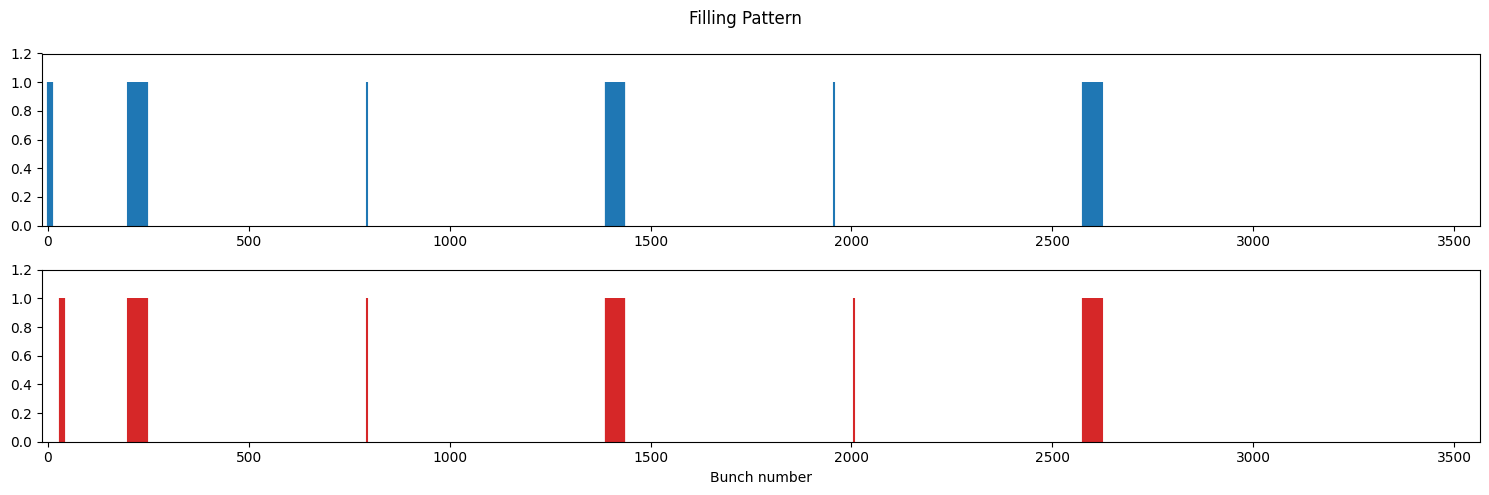

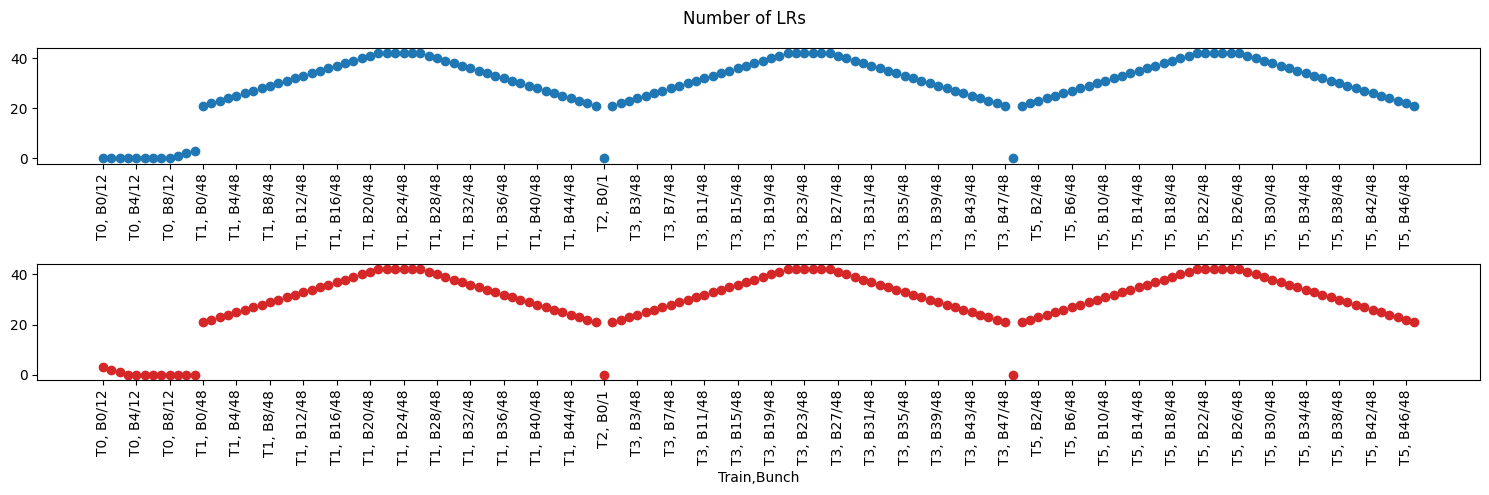

In [2]:
import json                                    
import numpy as np                          

#https://github.com/PyCOMPLETE/FillingPatterns       
import fillingpatterns as fp                            

INJscheme = {}
INJscheme['beam1'] = pd.DataFrame({ 'RFBucket':[1,  2001,   7941,   13881,  19571,  25761],
                                    'Length'  :[12, 48,     1,      48,     1,      48]})

INJscheme['beam2'] = pd.DataFrame({ 'RFBucket':[301,    2001,   7941,   13881,  20071,  25761],
                                    'Length'  :[12,     48,     1,      48,     1,      48]})




# Make filling from INJScheme
filling_scheme = {}                                                                                  
for beam in ['beam1','beam2']:
    filling_scheme[beam] = np.zeros(3564, dtype=int)

    for bucket_s,train_l in zip(INJscheme[beam].RFBucket,INJscheme[beam].Length):
        # get bunch number
        bunch_s = bucket_s//10
        bunch_e = bunch_s + train_l

        filling_scheme[beam][bunch_s:bunch_e] = 1

    filling_scheme[beam] = filling_scheme[beam].tolist()
#========================================================================               
                    
with open('MD7003_filling.json','w') as fid:                        
  json.dump(filling_scheme, fid)                         


#patt = fp.FillingPattern.from_json('MD8043_filling.json')                 
#patt.compute_beam_beam_schedule(n_lr_per_side=21) 
patt = sEff.getFillingPattern('MD7003_filling.json')
# Clearing some warnings
clear_output(wait=False)

# Showing relevant info
INJscheme['beam1'].insert(0,'Beam','Beam 1')
INJscheme['beam2'].insert(0,'Beam','Beam 2')
display(pd.concat([INJscheme['beam1'],INJscheme['beam2']],axis=1))

fig, axes = plt.subplots(figsize= (15,5),ncols=1, nrows=2,gridspec_kw={'height_ratios': [1, 1]})
for beam,bb_df,ax,color in zip(['b1','b2'],[patt.b1.bb_schedule,patt.b2.bb_schedule],axes,['C0','C3']):

    plt.sca(ax)
    plt.stem(bb_df.index,np.ones(len(bb_df.index)),markerfmt='none',basefmt='none',linefmt=color)

    plt.xlim([-15,3564])
    plt.ylim([0,1.2])
fig.suptitle('Filling Pattern')
plt.xlabel('Bunch number')
plt.tight_layout()



fig, axes = plt.subplots(figsize= (15,5),ncols=1, nrows=2,gridspec_kw={'height_ratios': [1, 1]})
for beam,bb_df,ax,color in zip(['b1','b2'],[patt.b1.bb_schedule,patt.b2.bb_schedule],axes,['C0','C3']):

    plt.sca(ax)
    plt.plot(bb_df['# of LR in ATLAS/CMS'].values,'o',color=color)

    plt.xticks(np.arange(len(bb_df))[::4],[f"T{_bunch['Train']}, B{_bunch['Tag']}" for _idx,_bunch in bb_df.iterrows()][::4],rotation=90)
fig.suptitle('Number of LRs')
plt.xlabel('Train,Bunch')
plt.tight_layout()

---
# Cross section calculation
---

In [3]:
import yaml

with open('config.yaml','r') as fid:
    configuration = yaml.safe_load(fid)

# Creating NXCALS variable containers
#============================
wires     = {'B1': [nx.NXCALSWire(loc = loc) for loc in ['L1B1','L5B1']],
             'B2': [nx.NXCALSWire(loc = loc) for loc in ['R1B2','R5B2']]}
beams     = [nx.NXCALSBeam(name) for name in ['B1','B2']]
buckets   = np.arange(3564)
#============================

# Loading data
#============================
database = sEff.importData(8330,DATA_PATH = '/home/lumimod/2022_07_26_NXCALS/2022_v3/')
# Taking subset defined in the config
if configuration['stop_ts'] == 'None':
    configuration['stop_ts'] = str(database['Timestamp'].max()).split('+')[0]

#temp for this example:
configuration['stop_ts'] = '2022-10-31 19:30'
database = database[(pd.Timestamp(configuration['start_ts'],tz='UTC')<database['Timestamp'])&
                    (pd.Timestamp(configuration['stop_ts'],tz='UTC')>database['Timestamp'])]
#============================

# Loading filling pattern with extra train info
patt = sEff.getFillingPattern('MD8043_filling.json')
clear_output(wait=False)


# Computing intensity avg (every 20 seconds) with calibration BCT_A+BCT_B
ref_ts   = pd.Timestamp(configuration['ref_ts'],tz='UTC')
ref_time = database.at_ts(ref_ts ,'Time',method='nearest')
BCT_avg  = sEff.compute_BCT_avg(database,STABLE_start=ref_time)
database = pd.concat([database,BCT_avg])
database = database.sort_index()

# Computing Lumi tot (ATLAS + CMS bunch by bunch)
Lumi_tot = sEff.computeLumiTot(database)
database = pd.concat([database,Lumi_tot])
database = database.sort_index()



# Computing effective cross section, both raw and smoothed 
xsection_df        = {}
xsection_smooth_df = {}
for beam in beams:
    xsection_df[beam.name]         = sEff.compute_lifetime_xsection(database,beam)
    xsection_smooth_df[beam.name]  = sEff.smooth_lifetime_xsection(database,beam)



/home/phbelang/abp/MD8043/WireDAQ/PandasPlus.py:55: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  _ts = self_cp.index[self_cp.index.get_loc(target, method=pdMethod)]
/home/phbelang/abp/MD8043/WireDAQ/SigmaEff.py:210: RuntimeWarning: invalid value encountered in divide
  lifetime = -data_N/dNdt
/home/phbelang/abp/MD8043/WireDAQ/SigmaEff.py:266: RuntimeWarning: invalid value encountered in divide
  lifetime = -data_N/dNdt
/home/phbelang/abp/MD8043/WireDAQ/SigmaEff.py:210: RuntimeWarning: invalid value encountered in divide
  lifetime = -data_N/dNdt
/home/phbelang/abp/MD8043/WireDAQ/SigmaEff.py:266: RuntimeWarning: invalid value encountered in divide
  lifetime = -data_N/dNdt


---
# Plotting Example
---

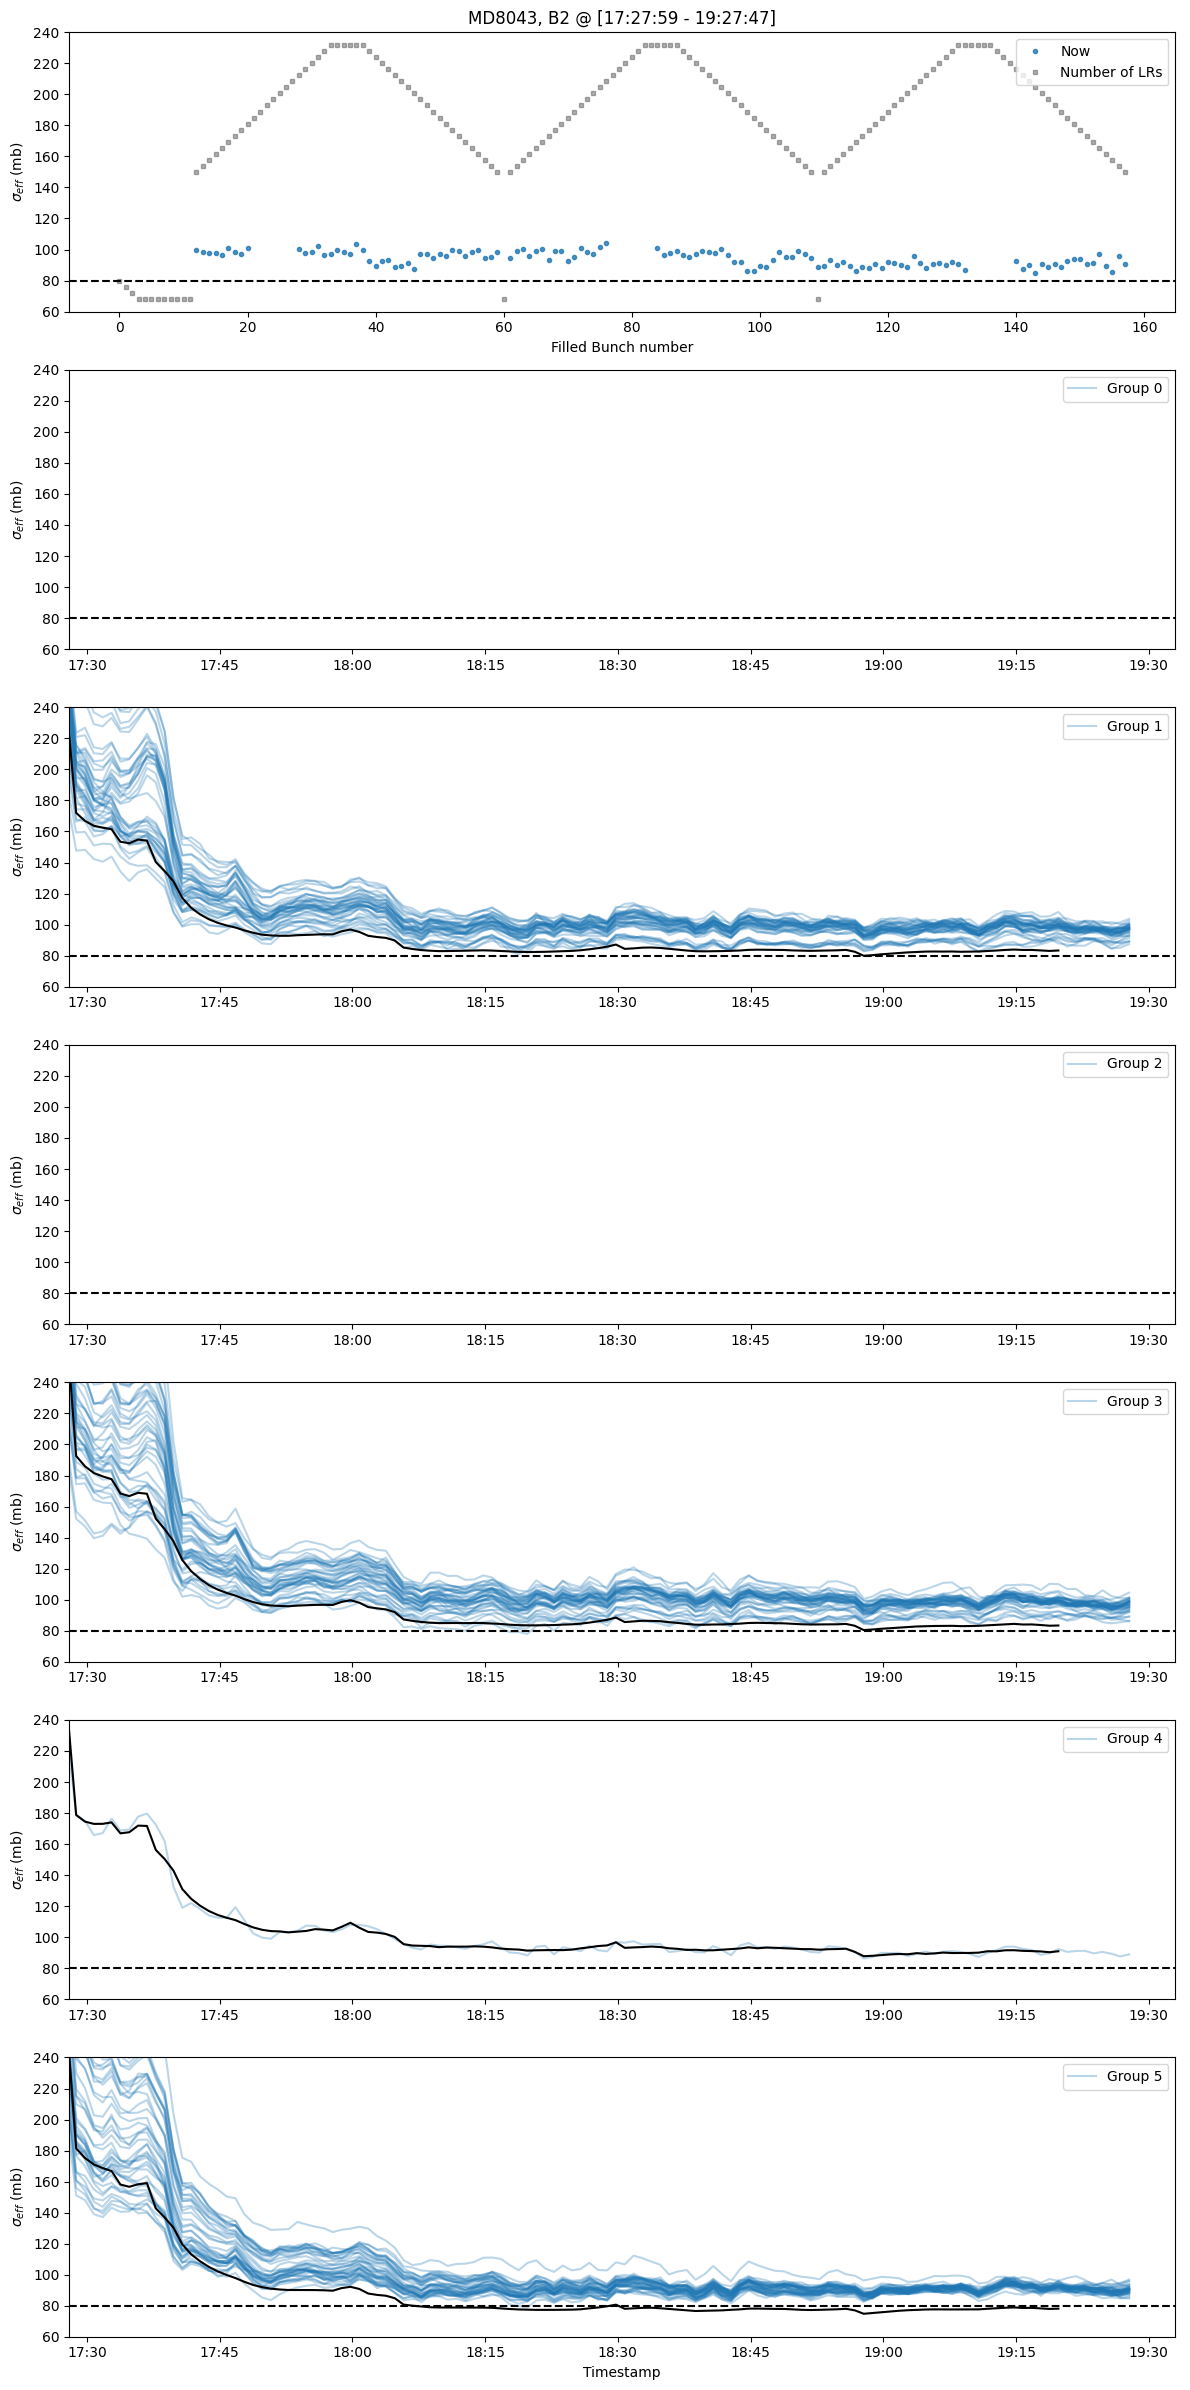

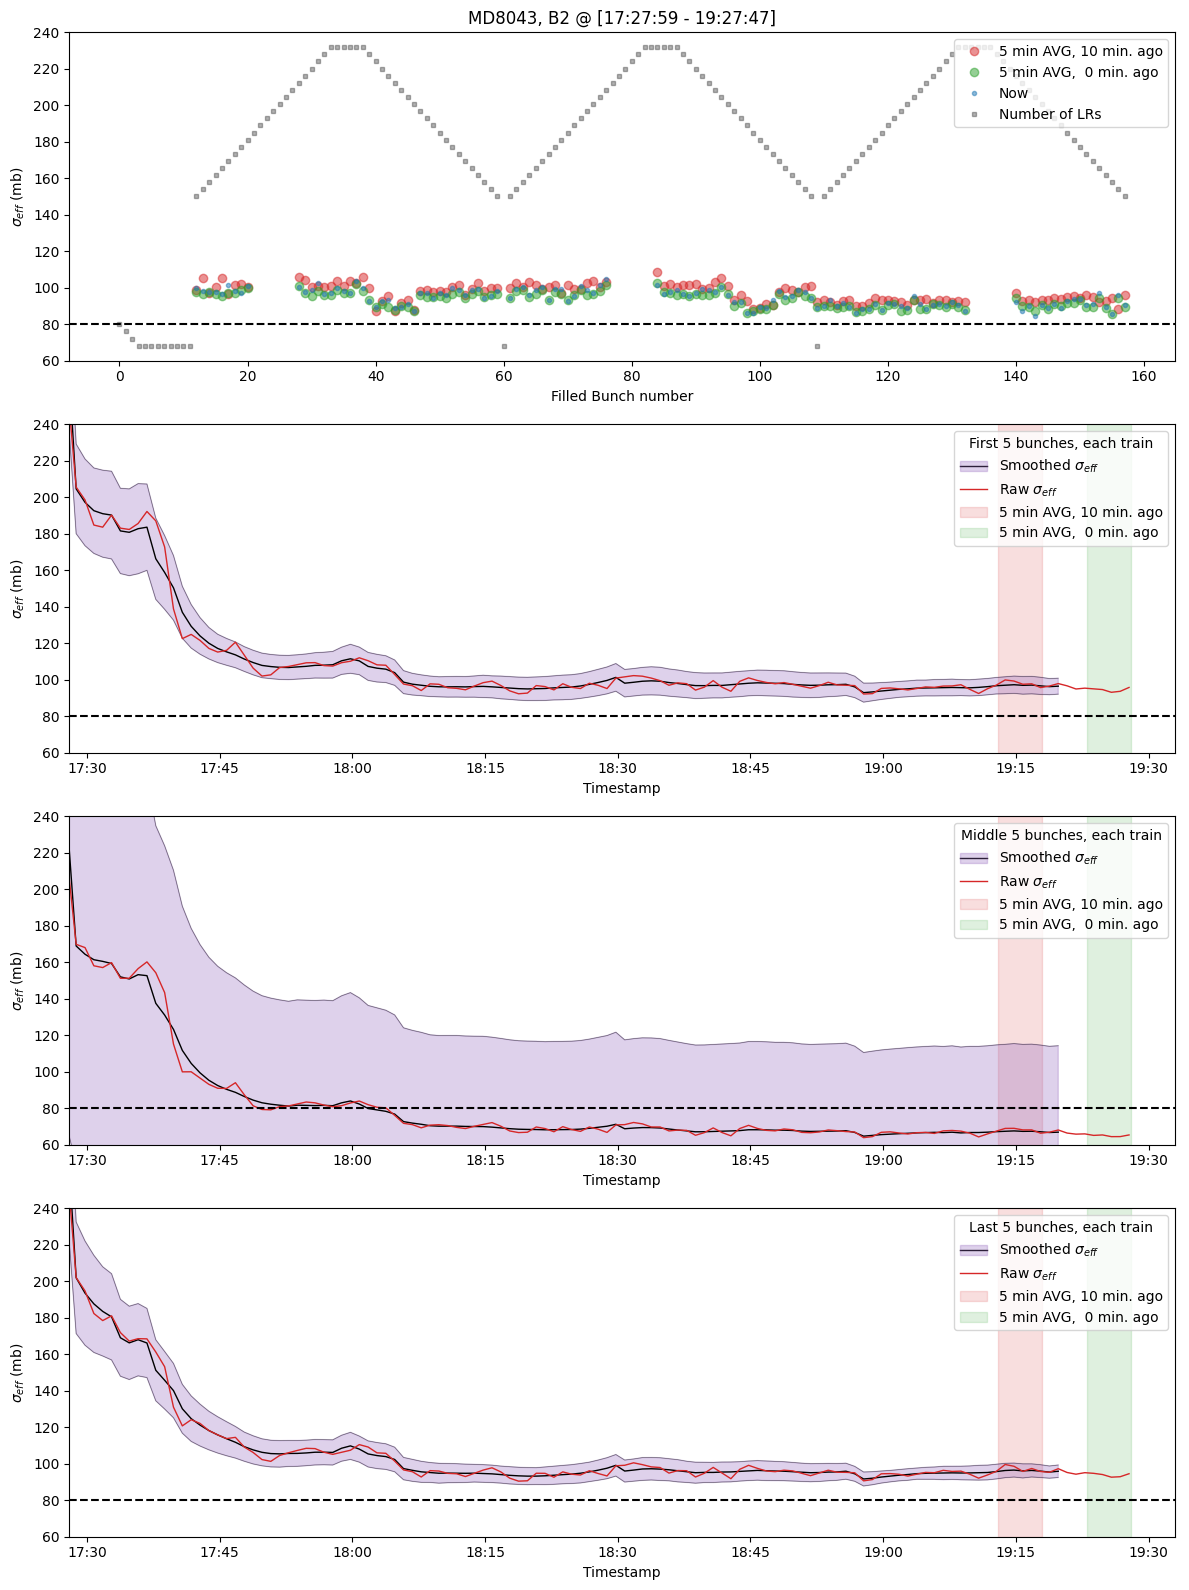

In [4]:
import plotter as MDplt

MDplt.plot_000(database,xsection_df,xsection_smooth_df,'B2',patt,configuration)
MDplt.plot_001(database,xsection_df,xsection_smooth_df,'B2',patt,configuration)